<center><img src='https://netacad.centralesupelec.fr/img/cs.jpg' width=200></center>

<h1>
<hr style=" border:none; height:3px;">
<center>Projet Machine Learning - Potabilité de l'eau</center>
<hr style=" border:none; height:3px;">
</h1>

###### @Maxime_Zennaro @Rayan_Smaoui @Wallerand_Peugeot

## 1. Imports

In [2]:
#Basic libraries
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

#sklearn functions to facilitate models evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

#sklearn classifier models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

#sklearn imputation modules
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

## 2. Data exploration

In [3]:
path = "data/"
drinking_water_potability = pd.read_csv(path + "drinking_water_potability.csv")

In [4]:
drinking_water_potability.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [5]:
drinking_water_potability.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690300,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833605,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762125,8.114887,359.950170,481.792305,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196010,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


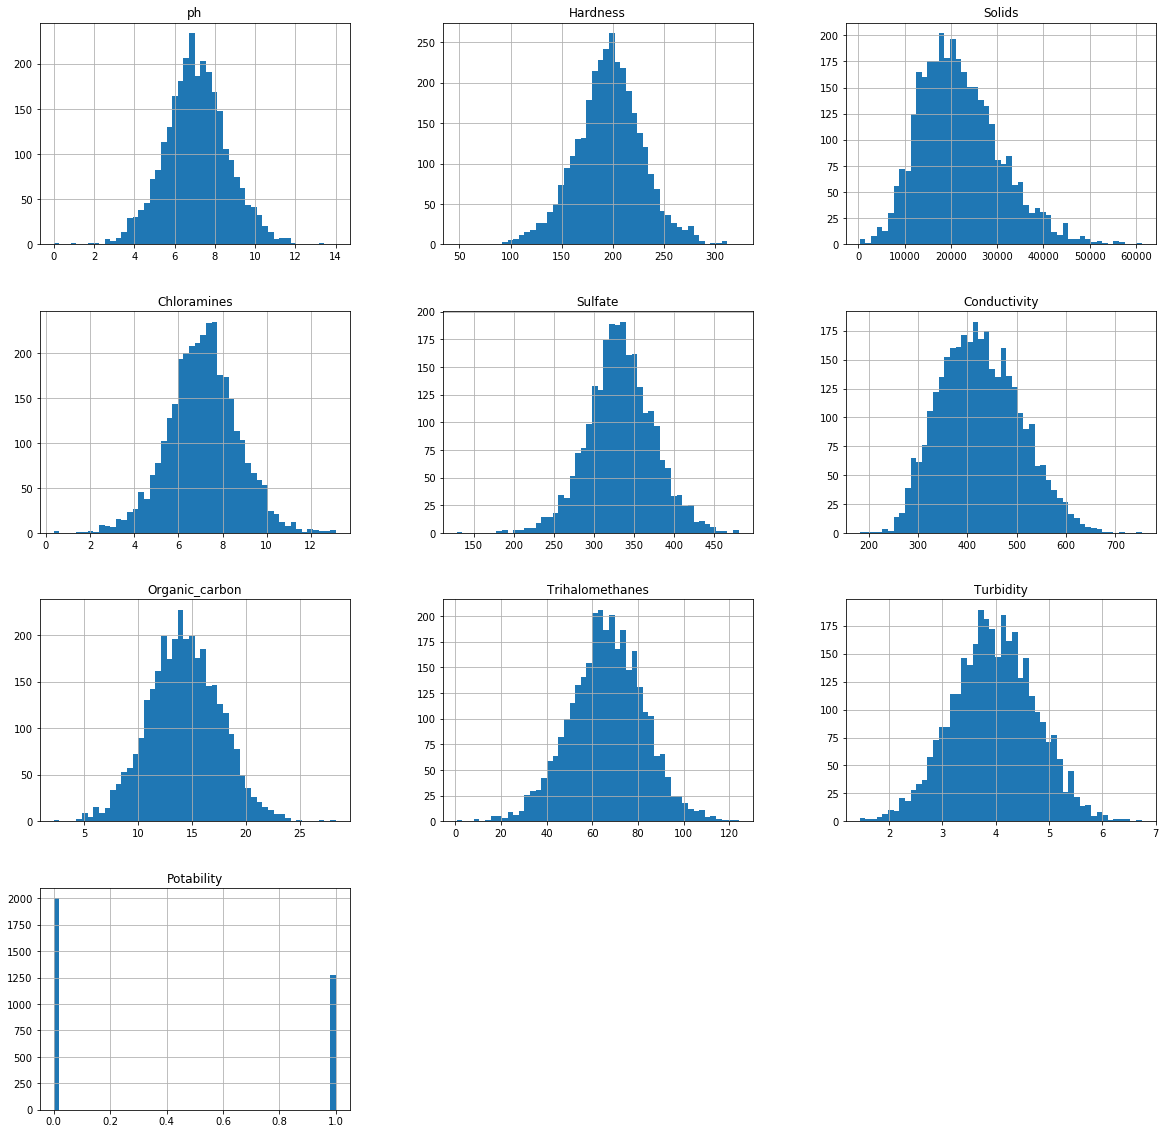

In [6]:
drinking_water_potability.hist(bins = 50, figsize = (20,20))
plt.show()

In [7]:
#Checking missing values
missing_df = drinking_water_potability.isna()
missing_df = np.round(100 * missing_df.sum()/len(drinking_water_potability), 2)
missing_df

ph                 14.99
Hardness            0.00
Solids              0.00
Chloramines         0.00
Sulfate            23.84
Conductivity        0.00
Organic_carbon      0.00
Trihalomethanes     4.95
Turbidity           0.00
Potability          0.00
dtype: float64

In [8]:
#Checking correlation with Potability
corr_matrix = drinking_water_potability.corr()
corr_matrix["Potability"].sort_values(ascending=False)

Potability         1.000000
Solids             0.033743
Chloramines        0.023779
Trihalomethanes    0.007130
Turbidity          0.001581
ph                -0.003556
Conductivity      -0.008128
Hardness          -0.013837
Sulfate           -0.023577
Organic_carbon    -0.030001
Name: Potability, dtype: float64

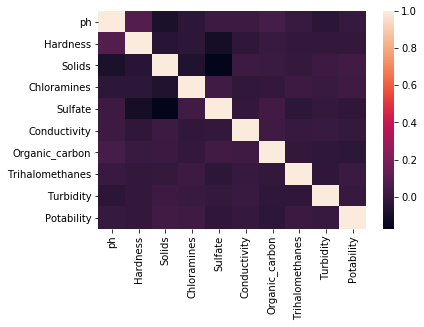

In [9]:
#Checking correlation matrix
sns.heatmap(drinking_water_potability.corr())

In [10]:
#Creating a scaled dataframe
df_scaled = drinking_water_potability.copy()
for col in df_scaled.columns :
    if col != 'Potability' :
        mean = df_scaled[col].mean()
        std = df_scaled[col].std()
        df_scaled[col] = df_scaled[col].apply(lambda x : (x-mean)/std)
    else :
        df_scaled[col] = df_scaled[col].apply(lambda x : str(x))

df_scaled.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
count,2.785000e+03,3.276000e+03,3.276000e+03,3.276000e+03,2.495000e+03,3.276000e+03,3.276000e+03,3.114000e+03,3.276000e+03
mean,1.060709e-14,5.015194e-16,2.483870e-15,-2.055497e-15,-1.773246e-14,-6.164788e-15,1.521134e-15,1.380613e-15,-4.304927e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.441264e+00,-4.529762e+00,-2.473966e+00,-4.276635e+00,-4.944264e+00,-3.027828e+00,-3.653077e+00,-4.059243e+00,-3.225068e+00
25%,-6.195136e-01,-5.936466e-01,-7.238810e-01,-6.284287e-01,-6.296057e-01,-7.481769e-01,-6.708163e-01,-6.523494e-01,-6.754064e-01
50%,-2.762458e-02,1.819146e-02,-1.238810e-01,5.067436e-03,-1.695520e-02,-5.345119e-02,-2.014179e-02,1.398405e-02,-1.506775e-02
75%,6.154799e-01,6.173390e-01,6.065606e-01,6.270101e-01,6.319747e-01,6.877555e-01,6.869921e-01,6.764250e-01,6.836823e-01
max,4.339911e+00,3.855092e+00,4.472006e+00,3.793052e+00,3.555435e+00,4.047526e+00,4.236500e+00,3.561278e+00,3.552379e+00


In [11]:
df_scaled.sample(5)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
2293,-0.794214,-0.359729,0.840301,-0.676555,0.351949,-0.254673,1.349157,0.976225,0.211596,0
2977,-1.921951,1.801931,0.752480,0.137907,-1.040280,0.200188,-1.505137,0.305770,0.577086,0
304,1.156096,-1.837940,0.673505,3.310630,NaN,-0.130848,-0.705847,0.180438,0.241929,1
2929,0.281114,0.881134,-1.583423,-0.515957,-0.592622,-0.579850,0.809203,-0.131716,-0.413101,0
2514,-0.346427,-0.590936,-0.396958,-0.656319,0.060860,0.807591,-0.227832,1.888581,0.123645,0


## 3. Basic models without data imputation

### 3.1 Logistic Regression + deleting columns with missing values

In [14]:
df_test1 = df_scaled.drop(columns = ['ph', 'Sulfate', 'Trihalomethanes'], axis = 1)

X = df_test1.drop(columns = ['Potability'], axis = 1)
y = df_test1['Potability']

clf = LogisticRegression()

score_lr0 = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_lr0 = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_lr0 = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- Logistic Regresion -----')
print('Accuracy : {} %'.format(np.round(score_lr,2)))
print('Precision : {} %'.format(np.round(precision_lr,2)))
print('Rappel : {} %'.format(np.round(recall_lr,2)))

----- Logistic Regresion -----
Accuracy : 60.99 %
Precision : 30.49 %
Rappel : 50.0 %


### 3.2 Decision Tree + deleting columns with missing values

In [13]:
df_test1 = df_scaled.drop(columns = ['ph', 'Sulfate', 'Trihalomethanes'], axis = 1)

X = df_test1.drop(columns = ['Potability'], axis = 1)
y = df_test1['Potability']

clf = DecisionTreeClassifier()

score_DT0 = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_DT0 = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_DT0 = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- Decision Tree -----')
print('Accuracy : {} %'.format(np.round(score_DT,2)))
print('Precision : {} %'.format(np.round(precision_DT,2)))
print('Rappel : {} %'.format(np.round(recall_DT,2)))

----- Decision Tree -----
Accuracy : 53.94 %
Precision : 51.75 %
Rappel : 50.99 %


### 3.3 KNN + deleting columns with missing values

In [21]:
df_test1 = df_scaled.drop(columns = ['ph', 'Sulfate', 'Trihalomethanes'], axis = 1)

X = df_test1.drop(columns = ['Potability'], axis = 1)
y = df_test1['Potability']

clf = KNeighborsClassifier()

score_KNN_d = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_KNN_d = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_KNN_d = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- KNN -----')
print('Accuracy : {} %'.format(np.round(score_KNN_d,2)))
print('Precision : {} %'.format(np.round(precision_KNN_d,2)))
print('Rappel : {} %'.format(np.round(recall_KNN_d,2)))

----- KNN -----
Accuracy : 56.96 %
Precision : 52.62 %
Rappel : 52.18 %


## 4. Basic Models with different imputations

### 4.1 Mean Imputation

In [15]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability']

X = imputer.fit_transform(X)

clf = LogisticRegression()

score_lr = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_lr = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_lr = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- Logistic Regresion -----')
print('Accuracy : {} %'.format(np.round(score_lr,2)))
print('Precision : {} %'.format(np.round(precision_lr,2)))
print('Rappel : {} %'.format(np.round(recall_lr,2)))



clf = DecisionTreeClassifier()

score_DT = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_DT = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_DT = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- Decision Tree -----')
print('Accuracy : {} %'.format(np.round(score_DT,2)))
print('Precision : {} %'.format(np.round(precision_DT,2)))
print('Rappel : {} %'.format(np.round(recall_DT,2)))


clf =  KNeighborsClassifier()

score_KNN = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_KNN = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_KNN = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- KNN -----')
print('Accuracy : {} %'.format(np.round(score_KNN,2)))
print('Precision : {} %'.format(np.round(precision_KNN,2)))
print('Rappel : {} %'.format(np.round(recall_KNN,2)))

----- Logistic Regresion -----
Accuracy : 61.02 %
Precision : 45.51 %
Rappel : 50.07 %
----- Decision Tree -----
Accuracy : 57.97 %
Precision : 55.53 %
Rappel : 54.66 %
----- KNN -----
Accuracy : 59.31 %
Precision : 55.67 %
Rappel : 54.89 %


### 4.2 KNN Imputation

In [16]:
imputer = KNNImputer(n_neighbors=5)

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability']

X = imputer.fit_transform(X)

clf = LogisticRegression()

score_lr = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_lr = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_lr = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- Logistic Regresion -----')
print('Accuracy : {} %'.format(np.round(score_lr,2)))
print('Precision : {} %'.format(np.round(precision_lr,2)))
print('Rappel : {} %'.format(np.round(recall_lr,2)))



clf = DecisionTreeClassifier()

score_DT = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_DT = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_DT = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- Decision Tree -----')
print('Accuracy : {} %'.format(np.round(score_DT,2)))
print('Precision : {} %'.format(np.round(precision_DT,2)))
print('Rappel : {} %'.format(np.round(recall_DT,2)))


clf =  KNeighborsClassifier()

score_KNN = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_KNN = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_KNN = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- KNN -----')
print('Accuracy : {} %'.format(np.round(score_KNN,2)))
print('Precision : {} %'.format(np.round(precision_KNN,2)))
print('Rappel : {} %'.format(np.round(recall_KNN,2)))

----- Logistic Regresion -----
Accuracy : 60.99 %
Precision : 44.79 %
Rappel : 50.06 %
----- Decision Tree -----
Accuracy : 56.29 %
Precision : 53.41 %
Rappel : 53.22 %
----- KNN -----
Accuracy : 59.03 %
Precision : 55.19 %
Rappel : 54.39 %


### 4.3 Iterative Imputation

In [38]:
imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability']

X = imputer.fit_transform(X)

clf = LogisticRegression()

score_lr = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_lr = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_lr = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- Logistic Regresion -----')
print('Accuracy : {} %'.format(np.round(score_lr,2)))
print('Precision : {} %'.format(np.round(precision_lr,2)))
print('Rappel : {} %'.format(np.round(recall_lr,2)))



clf = DecisionTreeClassifier()

score_DT = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_DT = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_DT = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- Decision Tree -----')
print('Accuracy : {} %'.format(np.round(score_DT,2)))
print('Precision : {} %'.format(np.round(precision_DT,2)))
print('Rappel : {} %'.format(np.round(recall_DT,2)))


clf =  KNeighborsClassifier()

score_KNN = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_KNN = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_KNN = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- KNN -----')
print('Accuracy : {} %'.format(np.round(score_KNN,2)))
print('Precision : {} %'.format(np.round(precision_KNN,2)))
print('Rappel : {} %'.format(np.round(recall_KNN,2)))

----- Logistic Regresion -----
Accuracy : 61.02 %
Precision : 45.51 %
Rappel : 50.07 %
----- Decision Tree -----
Accuracy : 56.72 %
Precision : 54.19 %
Rappel : 54.17 %
----- KNN -----
Accuracy : 59.52 %
Precision : 55.82 %
Rappel : 55.05 %


## 5. Stratigying to balance data

In [18]:
imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability']

X = imputer.fit_transform(X)

#Stratifying is done here
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)
X = np.concatenate((X_test, X_train))
y = pd.concat([y_test, y_train])

clf = LogisticRegression()

score_lr = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_lr = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_lr = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- Logistic Regresion -----')
print('Accuracy : {} %'.format(np.round(score_lr,2)))
print('Precision : {} %'.format(np.round(precision_lr,2)))
print('Rappel : {} %'.format(np.round(recall_lr,2)))



clf = DecisionTreeClassifier()

score_DT = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_DT = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_DT = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- Decision Tree -----')
print('Accuracy : {} %'.format(np.round(score_DT,2)))
print('Precision : {} %'.format(np.round(precision_DT,2)))
print('Rappel : {} %'.format(np.round(recall_DT,2)))


clf =  KNeighborsClassifier()

score_KNN_d = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_KNN_d = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_KNN_d = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- KNN -----')
print('Accuracy : {} %'.format(np.round(score_KNN_d,2)))
print('Precision : {} %'.format(np.round(precision_KNN_d,2)))
print('Rappel : {} %'.format(np.round(recall_KNN_d,2)))

----- Logistic Regresion -----
Accuracy : 61.08 %
Precision : 40.53 %
Rappel : 50.13 %
----- Decision Tree -----
Accuracy : 58.82 %
Precision : 57.76 %
Rappel : 56.74 %
----- KNN -----
Accuracy : 62.76 %
Precision : 59.82 %
Rappel : 58.16 %


## 6. More advanced models

### 6.1 Random Forest

In [22]:
imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability']

X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)
X = np.concatenate((X_test, X_train))
y = pd.concat([y_test, y_train])

clf = RandomForestClassifier()

accuracy_RF = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_RF = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_RF = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- Random Forest -----')
print('Accuracy : {} %'.format(np.round(accuracy_RF,2)))
print('Precision : {} %'.format(np.round(precision_RF,2)))
print('Rappel : {} %'.format(np.round(recall_RF,2)))

----- Random Forest -----
Accuracy : 66.91 %
Precision : 65.9 %
Rappel : 61.44 %


### 6.2 Support Vector Classification

In [23]:
imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability']

X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)
X = np.concatenate((X_test, X_train))
y = pd.concat([y_test, y_train])

clf = SVC()

accuracy_SVM = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_SVM = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_SVM = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- SVM -----')
print('Accuracy : {} %'.format(np.round(accuracy_SVM,2)))
print('Precision : {} %'.format(np.round(precision_SVM,2)))
print('Rappel : {} %'.format(np.round(recall_SVM,2)))

----- SVM -----
Accuracy : 67.92 %
Precision : 69.79 %
Rappel : 60.85 %


### 6.3 Gaussian Process Classification

In [40]:
imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability']

X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)
X = np.concatenate((X_test, X_train))
y = pd.concat([y_test, y_train])

clf = GaussianProcessClassifier()

accuracy_GC = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_GC = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_GC = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- Random Forest -----')
print('Accuracy : {} %'.format(np.round(accuracy_GC,2)))
print('Precision : {} %'.format(np.round(precision_GC,2)))
print('Rappel : {} %'.format(np.round(recall_GC,2)))

----- Random Forest -----
Accuracy : 67.89 %
Precision : 67.91 %
Rappel : 61.75 %


### 6.4 Multi Layer Perceptron Classification

In [25]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability']

X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)
X = np.concatenate((X_test, X_train))
y = pd.concat([y_test, y_train])

clf = MLPClassifier()

accuracy_MLP = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_MLP = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_MLP = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- Random Forest -----')
print('Accuracy : {} %'.format(np.round(accuracy_MLP,2)))
print('Precision : {} %'.format(np.round(precision_MLP,2)))
print('Rappel : {} %'.format(np.round(recall_MLP,2)))

----- Random Forest -----
Accuracy : 67.31 %
Precision : 66.21 %
Rappel : 62.32 %


## 7. Parameters Optimisation : Grid Search

### 7.1 Random Forest Grid search

In [15]:
imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability']

X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

clf2 = RandomForestClassifier()
parameters = {'n_estimators':[50,100, 200], 'criterion':['gini', 'entropy'], 'max_depth' : [None,5,10], 'max_features' : ['auto', 'log2']}
clf = GridSearchCV(clf2, parameters, n_jobs = -1, scoring='precision_macro')
clf = clf.fit(X_train, y_train)

print('score :',clf.score(X_test, y_test))
pd.DataFrame(clf.cv_results_).sort_values(by = 'mean_test_score', ascending = False).head()

score : 0.7024082568807339


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
25,0.542622,0.112423,0.016100,0.000744,entropy,5,auto,100,"{'criterion': 'entropy', 'max_depth': 5, 'max_...",0.766472,0.719732,0.695451,0.769704,0.653788,0.721029,0.043844,1
7,0.363935,0.041879,0.018684,0.004636,gini,5,auto,100,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.745593,0.723009,0.725295,0.762538,0.624952,0.716277,0.047888,2
26,1.136724,0.203265,0.032199,0.006304,entropy,5,auto,200,"{'criterion': 'entropy', 'max_depth': 5, 'max_...",0.776709,0.710024,0.716524,0.762538,0.603951,0.713949,0.060698,3
29,0.981292,0.011668,0.028025,0.000974,entropy,5,log2,200,"{'criterion': 'entropy', 'max_depth': 5, 'max_...",0.753680,0.702064,0.711679,0.774439,0.608663,0.710105,0.057263,4
28,0.539045,0.101282,0.017888,0.001778,entropy,5,log2,100,"{'criterion': 'entropy', 'max_depth': 5, 'max_...",0.771567,0.661267,0.706475,0.767419,0.613230,0.703991,0.061088,5


In [19]:
imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability']

X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)
X = np.concatenate((X_test, X_train))
y = pd.concat([y_test, y_train])

clf = RandomForestClassifier(criterion = 'entropy', max_depth = 5)

accuracy_RF = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_RF = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_RF = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- Random Forest -----')
print('Accuracy : {} %'.format(np.round(accuracy_RF,2)))
print('Precision : {} %'.format(np.round(precision_RF,2)))
print('Rappel : {} %'.format(np.round(recall_RF,2)))

----- Random Forest -----
Accuracy : 64.13 %
Precision : 69.87 %
Rappel : 54.91 %


### 7.2 SVC Grid search

In [16]:
imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability']

X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

clf3 = SVC(probability=True, kernel = 'rbf')
parameters = [
    {'kernel':['rbf'] , 'C': [0.1, 0.5, 1], 'gamma': ['scale', 'auto', 0.01, 0.001], 'tol': [0.01, 0.001, 0.0001]},
    {'kernel':['poly'] , 'C': [0.1, 0.5, 1], 'gamma': ['scale', 'auto', 0.01, 0.001], 'degree': [2,3,4]}
 ]
clf = GridSearchCV(clf3, parameters, n_jobs = -1, scoring='precision_macro')
clf = clf.fit(X_train, y_train)

print('score :',clf.score(X_test, y_test))
pd.DataFrame(clf.cv_results_).sort_values(by = 'mean_test_score', ascending = False).head()

score : 0.6637931034482758


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,param_tol,param_degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
41,1.030585,0.109296,0.037367,0.001193,0.1,auto,poly,NaN,3,"{'C': 0.1, 'degree': 3, 'gamma': 'auto', 'kern...",0.806748,0.681352,0.805726,0.805102,0.808642,0.781514,0.050095,1
40,0.991031,0.097854,0.037367,0.001013,0.1,scale,poly,NaN,3,"{'C': 0.1, 'degree': 3, 'gamma': 'scale', 'ker...",0.806748,0.681352,0.638661,0.805102,0.809278,0.748229,0.073299,2
45,0.930408,0.007259,0.036572,0.000397,0.1,auto,poly,NaN,4,"{'C': 0.1, 'degree': 4, 'gamma': 'auto', 'kern...",0.701125,0.745702,0.736524,0.768620,0.752036,0.740802,0.022435,3
37,0.891967,0.027397,0.036771,0.001540,0.1,auto,poly,NaN,2,"{'C': 0.1, 'degree': 2, 'gamma': 'auto', 'kern...",0.715846,0.789752,0.704622,0.748134,0.731294,0.737929,0.029768,4
36,0.872969,0.032080,0.037169,0.003180,0.1,scale,poly,NaN,2,"{'C': 0.1, 'degree': 2, 'gamma': 'scale', 'ker...",0.700066,0.791737,0.713651,0.750940,0.710116,0.733302,0.033924,5


In [20]:
imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability']

X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)
X = np.concatenate((X_test, X_train))
y = pd.concat([y_test, y_train])

clf = SVC(kernel = 'poly', C= 0.1, degree = 3)

accuracy_SVM = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_SVM = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_SVM = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- SVM -----')
print('Accuracy : {} %'.format(np.round(accuracy_SVM,2)))
print('Precision : {} %'.format(np.round(precision_SVM,2)))
print('Rappel : {} %'.format(np.round(recall_SVM,2)))

----- SVM -----
Accuracy : 61.39 %
Precision : 71.37 %
Rappel : 50.57 %


### 7.3 KNN Grid search

In [17]:
imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability']

X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

clf2 = KNeighborsClassifier()
parameters = {'n_neighbors':[3,5,8,10,12,15,20,25], 'weights':['uniform', 'distance']}
clf = GridSearchCV(clf2, parameters, n_jobs = -1, scoring='precision_macro')
clf = clf.fit(X_train, y_train)

print('score :',clf.score(X_test, y_test))
pd.DataFrame(clf.cv_results_).sort_values(by = 'mean_test_score', ascending = False).head()

score : 0.679453781512605


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
14,0.007155,0.000398,0.045915,0.003945,25,uniform,"{'n_neighbors': 25, 'weights': 'uniform'}",0.653834,0.592938,0.629289,0.642330,0.666840,0.637046,0.025311,1
15,0.007354,0.001013,0.030014,0.002301,25,distance,"{'n_neighbors': 25, 'weights': 'distance'}",0.625949,0.604960,0.638514,0.646666,0.659557,0.635129,0.018632,2
12,0.007354,0.001843,0.048895,0.005458,20,uniform,"{'n_neighbors': 20, 'weights': 'uniform'}",0.582867,0.619684,0.621853,0.657181,0.653346,0.626986,0.026955,3
13,0.008149,0.000974,0.034187,0.002318,20,distance,"{'n_neighbors': 20, 'weights': 'distance'}",0.613095,0.590872,0.610323,0.618900,0.669788,0.620596,0.026336,4
8,0.007155,0.001461,0.048300,0.011634,12,uniform,"{'n_neighbors': 12, 'weights': 'uniform'}",0.627043,0.588071,0.580087,0.607879,0.642888,0.609193,0.023448,5


In [27]:
imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability']

X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)
X = np.concatenate((X_test, X_train))
y = pd.concat([y_test, y_train])

clf =  KNeighborsClassifier(n_neighbors = 25, weights = 'uniform')

score_KNN = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_KNN = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_KNN = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- KNN -----')
print('Accuracy : {} %'.format(np.round(score_KNN,2)))
print('Precision : {} %'.format(np.round(precision_KNN,2)))
print('Rappel : {} %'.format(np.round(recall_KNN,2)))

----- KNN -----
Accuracy : 64.59 %
Precision : 64.18 %
Rappel : 56.82 %


### 7.4 MLP Grid search

In [30]:
imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability']

X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

clf2 = MLPClassifier()
parameters = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
clf = GridSearchCV(clf2, parameters, n_jobs = -1, scoring='precision_macro')
clf = clf.fit(X_train, y_train)

print('score :',clf.score(X_test, y_test))
pd.DataFrame(clf.cv_results_).sort_values(by = 'mean_test_score', ascending = False).head()

score : 0.3052503052503053


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,3.686652,0.445522,0.006361,0.001014,tanh,0.0001,"(50, 50, 50)",adaptive,sgd,"{'activation': 'tanh', 'alpha': 0.0001, 'hidde...",0.805499,0.640787,0.664994,0.726688,0.634979,0.694589,0.064273,1
42,5.895900,1.020209,0.006361,0.000796,relu,0.0001,"(50, 100, 50)",constant,sgd,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...",0.656322,0.665139,0.673136,0.806982,0.670448,0.694405,0.056580,2
69,2.430000,0.525673,0.005565,0.002710,relu,0.05,"(100,)",adaptive,sgd,"{'activation': 'relu', 'alpha': 0.05, 'hidden_...",0.714046,0.690159,0.650811,0.724001,0.684665,0.692737,0.025539,3
48,2.382140,0.322295,0.005168,0.000973,relu,0.0001,"(100,)",constant,sgd,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...",0.664035,0.729206,0.702771,0.700036,0.647219,0.688653,0.029313,4
51,2.066735,0.366914,0.004572,0.000488,relu,0.0001,"(100,)",adaptive,sgd,"{'activation': 'relu', 'alpha': 0.0001, 'hidde...",0.664935,0.723009,0.682899,0.691485,0.672010,0.686868,0.020224,5


In [31]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability']

X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)
X = np.concatenate((X_test, X_train))
y = pd.concat([y_test, y_train])

clf = MLPClassifier(activation = 'tanh', hidden_layer_sizes = (50,50,50), solver = 'sgd', alpha = 0.0001, learning_rate = 'adaptive')

accuracy_MLP = 100 * cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean()
precision_MLP = 100 * cross_val_score(clf, X, y, cv=5, scoring='precision_macro').mean()
recall_MLP = 100 * cross_val_score(clf, X, y, cv=5, scoring='recall_macro').mean()

print('----- Random Forest -----')
print('Accuracy : {} %'.format(np.round(accuracy_MLP,2)))
print('Precision : {} %'.format(np.round(precision_MLP,2)))
print('Rappel : {} %'.format(np.round(recall_MLP,2)))

----- Random Forest -----
Accuracy : 63.83 %
Precision : 70.71 %
Rappel : 53.09 %


## 8. Grouping models together

### 8.1 Voting Classifier 

In [32]:
imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability'].apply(lambda x:str(x))

X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify = y)

X = np.concatenate((X_test, X_train))
y = pd.concat([y_test, y_train])

In [33]:

clf1 = RandomForestClassifier(criterion = 'entropy', max_depth = 5)
clf2 = SVC(kernel = 'poly', C= 0.1, degree = 3, probability = True)
clf3 = GaussianProcessClassifier()
clf4 = KNeighborsClassifier(n_neighbors = 25, weights = 'uniform')
clf5 = MLPClassifier(activation = 'tanh', hidden_layer_sizes = (50,50,50), solver = 'sgd', alpha = 0.0001, learning_rate = 'adaptive')

estimators=[ ('rf', clf1), ('svc', clf2), ('gpc', clf3), ('knn', clf4), ('MLP', clf5)]
combinations_1 = list(combinations(estimators, 1))
combinations_2 = list(combinations(estimators, 2))
combinations_3 = list(combinations(estimators, 3))
combinations_4 = list(combinations(estimators, 4))
combinations_5 = list(combinations(estimators, 5))
combinations_all = combinations_1+combinations_2+combinations_3+combinations_4+combinations_5


combs = {}
results = {}

for k in range(len(combinations_all)) :
    comb = combinations_all[k]
    eclf = VotingClassifier(estimators= list(comb), voting='soft', n_jobs = -1)
    scores = cross_val_score(eclf, X, y, cv=5, scoring = 'precision_macro')
    classifiers = [comb[k][0] for k in range(len(comb))]
    print('Combination', classifiers, ' : ',scores.mean())
    combs[k] = classifiers
    results[k] = scores.mean()

Combination ['rf']  :  0.709726996359381
Combination ['svc']  :  0.7413275314516238
Combination ['gpc']  :  0.6734782459061222
Combination ['knn']  :  0.649704003202998
Combination ['MLP']  :  0.7157342236880498
Combination ['rf', 'svc']  :  0.7163497581899095
Combination ['rf', 'gpc']  :  0.719709462492529
Combination ['rf', 'knn']  :  0.7118225947020311
Combination ['rf', 'MLP']  :  0.7099797807215099
Combination ['svc', 'gpc']  :  0.67364266031955
Combination ['svc', 'knn']  :  0.7072285901529092
Combination ['svc', 'MLP']  :  0.7420054810290546
Combination ['gpc', 'knn']  :  0.6704189283722313
Combination ['gpc', 'MLP']  :  0.7035648332631698
Combination ['knn', 'MLP']  :  0.7162987072464266
Combination ['rf', 'svc', 'gpc']  :  0.737373142601019
Combination ['rf', 'svc', 'knn']  :  0.7549022863782028
Combination ['rf', 'svc', 'MLP']  :  0.7368370757474705
Combination ['rf', 'gpc', 'knn']  :  0.7168557662266405
Combination ['rf', 'gpc', 'MLP']  :  0.7217532037683426
Combination ['rf

Best Combination ['rf', 'svc', 'knn']  :  0.7549

In [34]:
# Best combination

clf1 = RandomForestClassifier(criterion = 'entropy', max_depth = 5)
clf2 = SVC(kernel = 'poly', C= 0.1, degree = 3, probability = True)
clf4 = KNeighborsClassifier(n_neighbors = 25, weights = 'uniform')

eclf = VotingClassifier(estimators=[('rf', clf1), ('svc', clf2), ('knn', clf3)], voting='soft')

accuracy_VC = 100 * cross_val_score(eclf, X, y, cv=5, scoring='accuracy').mean()
precision_VC = 100 * cross_val_score(eclf, X, y, cv=5, scoring='precision_macro').mean()
recall_VC = 100 * cross_val_score(eclf, X, y, cv=5, scoring='recall_macro').mean()

print('----- Voting Classifier -----')
print('Accuracy : {} %'.format(np.round(accuracy_VC,2)))
print('Precision : {} %'.format(np.round(precision_VC,2)))
print('Rappel : {} %'.format(np.round(recall_VC,2)))

----- Voting Classifier -----
Accuracy : 63.22 %
Precision : 74.17 %
Rappel : 53.12 %


### 8.2 Stacking Classifier

In [35]:
imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability'].apply(lambda x:str(x))

X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify = y)

X = np.concatenate((X_test, X_train))
y = pd.concat([y_test, y_train])

clf1 = RandomForestClassifier(criterion = 'entropy', max_depth = 5)
clf2 = SVC(kernel = 'poly', C= 0.1, degree = 3, probability = True)
clf3 = GaussianProcessClassifier()
clf4 = KNeighborsClassifier(n_neighbors = 25, weights = 'uniform')
clf5 = MLPClassifier(activation = 'tanh', hidden_layer_sizes = (50,50,50), solver = 'sgd', alpha = 0.0001, learning_rate = 'adaptive')

estimators=[ ('rf', clf1), ('svc', clf2), ('gpc', clf3), ('knn', clf4), ('MLP', clf5)]
combinations_1 = list(combinations(estimators, 1))
combinations_2 = list(combinations(estimators, 2))
combinations_3 = list(combinations(estimators, 3))
combinations_4 = list(combinations(estimators, 4))
combinations_5 = list(combinations(estimators, 5))
combinations_all = combinations_1+combinations_2+combinations_3+combinations_4+combinations_5


for k in range(len(combinations_all)) :
    comb = combinations_all[k]
    eclf = StackingClassifier(estimators= list(comb), n_jobs = -1)
    scores = cross_val_score(eclf, X, y, cv=5, scoring = 'precision_macro')
    classifiers = [comb[k][0] for k in range(len(comb))]
    print('Combination', classifiers, ' : ',scores.mean())


Combination ['rf']  :  0.6810075504922201
Combination ['svc']  :  0.4052260663664099
Combination ['gpc']  :  0.6855135580216263
Combination ['knn']  :  0.6381386735143206
Combination ['MLP']  :  0.6847715274954045
Combination ['rf', 'svc']  :  0.6724226732048397
Combination ['rf', 'gpc']  :  0.6787872115377539
Combination ['rf', 'knn']  :  0.6687398779279891
Combination ['rf', 'MLP']  :  0.668484845713698
Combination ['svc', 'gpc']  :  0.6822171007208994
Combination ['svc', 'knn']  :  0.6339835209178613
Combination ['svc', 'MLP']  :  0.7005460857119639
Combination ['gpc', 'knn']  :  0.6510893113638774
Combination ['gpc', 'MLP']  :  0.6783930895038759
Combination ['knn', 'MLP']  :  0.6525202046531206
Combination ['rf', 'svc', 'gpc']  :  0.6628971181796273
Combination ['rf', 'svc', 'knn']  :  0.6679214618809783
Combination ['rf', 'svc', 'MLP']  :  0.6527889269062368
Combination ['rf', 'gpc', 'knn']  :  0.6673211745490694
Combination ['rf', 'gpc', 'MLP']  :  0.6730403731771186
Combination

Best Combination ['svc', 'MLP']  :  0.7005

In [36]:
#Best combination

clf2 = SVC(kernel = 'poly', C= 0.1, degree = 3, probability = True)
clf5 = MLPClassifier(activation = 'tanh', hidden_layer_sizes = (50,50,50), solver = 'sgd', alpha = 0.0001, learning_rate = 'adaptive')

eclf = StackingClassifier(estimators=[('svc', clf2), ('MLP', clf5)], n_jobs = -1)

accuracy_SC = 100 * cross_val_score(eclf, X, y, cv=5, scoring='accuracy').mean()
precision_SC = 100 * cross_val_score(eclf, X, y, cv=5, scoring='precision_macro').mean()
recall_SC = 100 * cross_val_score(eclf, X, y, cv=5, scoring='recall_macro').mean()

print('----- Stacking Classifier -----')
print('Accuracy : {} %'.format(np.round(accuracy_SC,2)))
print('Precision : {} %'.format(np.round(precision_SC,2)))
print('Rappel : {} %'.format(np.round(recall_SC,2)))

----- Stacking Classifier -----
Accuracy : 63.43 %
Precision : 73.17 %
Rappel : 52.54 %


## 8.3 Other metrics

In [174]:
def classification_metrics(y_test, y_pred, print_ = False):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for k in range(len(y_test)):
        if y_test[k] == '1':
            if y_pred[k] == '1':
                tp += 1
            elif y_pred[k] == '0':
                fn += 1
            else :
                print('Error')
        elif y_test[k] == '0':
            if y_pred[k] == '0':
                tn += 1
            elif y_pred[k] == '1':
                fp += 1
            else :
                print('Error')
    acc = (tp+tn)/(tp+tn+fp+fn)
    prec = (tp)/(tp+fp)
    rec = (tp)/(tp+fn)
    f1 = 2*(prec*rec)/(prec+rec)
    
    if print_ :
        print('(tp, tn, fp, fn) :',(tp,tn,fp,fn))  
        print('Accuracy : ', round(acc, 3)) 
        print('Precision : ', round(prec, 3))   
        print('Accuracy : ', round(acc, 3))
        print('F1 Score :', round(f1, 3))
    return acc, prec, rec, f1

In [169]:
imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability']

X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify = y)

clf1 = RandomForestClassifier(n_estimators = 200)
clf4 = KNeighborsClassifier(n_neighbors = 20, weights = 'distance')
clf5 = MLPClassifier()

estimators=[ ('rf', clf1), ('knn', clf4), ('MLP', clf5)]

eclf = VotingClassifier(estimators= estimators, voting='soft', n_jobs = -1).fit(X_train, y_train)
y_pred = eclf.predict(X_test)

In [175]:
classification_metrics(np.array(y_test), y_pred, print_=True)

(tp, tn, fp, fn) : (93, 358, 42, 163)
Accuracy :  0.688
Precision :  0.689
Accuracy :  0.688
F1 Score : 0.476


(0.6875, 0.6888888888888889, 0.36328125, 0.4757033248081841)

In [176]:
#Voting classifier
imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability'].apply(lambda x:str(x))

X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify = y)

clf1 = RandomForestClassifier(n_estimators = 200)
clf2 = SVC(probability=True)
clf3 = GaussianProcessClassifier()
clf4 = KNeighborsClassifier(n_neighbors = 20, weights = 'distance')
clf5 = MLPClassifier()

estimators=[ ('rf', clf1), ('svc', clf2), ('gpc', clf3), ('knn', clf4), ('MLP', clf5)]
combinations_1 = list(combinations(estimators, 1))
combinations_2 = list(combinations(estimators, 2))
combinations_3 = list(combinations(estimators, 3))
combinations_4 = list(combinations(estimators, 4))
combinations_5 = list(combinations(estimators, 5))
combinations_all = combinations_1+combinations_2+combinations_3+combinations_4+combinations_5


results = {}

for k in range(len(combinations_all)) :
    comb = combinations_all[k]
    eclf = VotingClassifier(estimators= estimators, voting='soft', n_jobs = -1).fit(X_train, y_train)
    y_pred = eclf.predict(X_test)
    scores = classification_metrics(np.array(y_test), y_pred)
    classifiers = [comb[k][0] for k in range(len(comb))]
    print(k, ':', classifiers)
    results[k] = scores

0 : ['rf']
1 : ['svc']
2 : ['gpc']
3 : ['knn']
4 : ['MLP']
5 : ['rf', 'svc']
6 : ['rf', 'gpc']
7 : ['rf', 'knn']
8 : ['rf', 'MLP']
9 : ['svc', 'gpc']
10 : ['svc', 'knn']
11 : ['svc', 'MLP']
12 : ['gpc', 'knn']
13 : ['gpc', 'MLP']
14 : ['knn', 'MLP']
15 : ['rf', 'svc', 'gpc']
16 : ['rf', 'svc', 'knn']
17 : ['rf', 'svc', 'MLP']
18 : ['rf', 'gpc', 'knn']
19 : ['rf', 'gpc', 'MLP']
20 : ['rf', 'knn', 'MLP']
21 : ['svc', 'gpc', 'knn']
22 : ['svc', 'gpc', 'MLP']
23 : ['svc', 'knn', 'MLP']
24 : ['gpc', 'knn', 'MLP']
25 : ['rf', 'svc', 'gpc', 'knn']
26 : ['rf', 'svc', 'gpc', 'MLP']
27 : ['rf', 'svc', 'knn', 'MLP']
28 : ['rf', 'gpc', 'knn', 'MLP']
29 : ['svc', 'gpc', 'knn', 'MLP']
30 : ['rf', 'svc', 'gpc', 'knn', 'MLP']


In [199]:
pd.DataFrame.from_dict(results, orient = 'index', columns=['accuracy', 'precision', 'recall', 'f1 score']).sort_values(by = 'f1 score', ascending = False).head()

,accuracy,precision,recall,f1 score
15,0.711890,0.718954,0.429688,0.537897
17,0.705793,0.695652,0.437500,0.537170
5,0.702744,0.689441,0.433594,0.532374
3,0.704268,0.698718,0.425781,0.529126
19,0.705793,0.705882,0.421875,0.528117


In [193]:
#Stacking classifier
imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability'].apply(lambda x:str(x))

X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify = y)

clf1 = RandomForestClassifier(n_estimators = 200)
clf2 = SVC(probability=True)
clf3 = GaussianProcessClassifier()
clf4 = KNeighborsClassifier(n_neighbors = 20, weights = 'distance')
clf5 = MLPClassifier()

estimators=[ ('rf', clf1), ('svc', clf2), ('gpc', clf3), ('knn', clf4), ('MLP', clf5)]
combinations_1 = list(combinations(estimators, 1))
combinations_2 = list(combinations(estimators, 2))
combinations_3 = list(combinations(estimators, 3))
combinations_4 = list(combinations(estimators, 4))
combinations_5 = list(combinations(estimators, 5))
combinations_all = combinations_1+combinations_2+combinations_3+combinations_4+combinations_5


results = {}

for k in range(len(combinations_all)) :
    comb = combinations_all[k]
    eclf = StackingClassifier(estimators= estimators, n_jobs = -1).fit(X_train, y_train)
    y_pred = eclf.predict(X_test)
    scores = classification_metrics(np.array(y_test), y_pred)
    classifiers = [comb[k][0] for k in range(len(comb))]
    print(k, ':', classifiers)
    results[k] = scores

0 : ['rf']
1 : ['svc']
2 : ['gpc']
3 : ['knn']
4 : ['MLP']
5 : ['rf', 'svc']
6 : ['rf', 'gpc']
7 : ['rf', 'knn']
8 : ['rf', 'MLP']
9 : ['svc', 'gpc']
10 : ['svc', 'knn']
11 : ['svc', 'MLP']
12 : ['gpc', 'knn']
13 : ['gpc', 'MLP']
14 : ['knn', 'MLP']
15 : ['rf', 'svc', 'gpc']
16 : ['rf', 'svc', 'knn']
17 : ['rf', 'svc', 'MLP']
18 : ['rf', 'gpc', 'knn']
19 : ['rf', 'gpc', 'MLP']
20 : ['rf', 'knn', 'MLP']
21 : ['svc', 'gpc', 'knn']
22 : ['svc', 'gpc', 'MLP']
23 : ['svc', 'knn', 'MLP']
24 : ['gpc', 'knn', 'MLP']
25 : ['rf', 'svc', 'gpc', 'knn']
26 : ['rf', 'svc', 'gpc', 'MLP']
27 : ['rf', 'svc', 'knn', 'MLP']
28 : ['rf', 'gpc', 'knn', 'MLP']
29 : ['svc', 'gpc', 'knn', 'MLP']
30 : ['rf', 'svc', 'gpc', 'knn', 'MLP']


In [200]:
pd.DataFrame.from_dict(results, orient = 'index', columns=['accuracy', 'precision', 'recall', 'f1 score']).sort_values(by = 'f1 score', ascending = False).head()

,accuracy,precision,recall,f1 score
15,0.711890,0.718954,0.429688,0.537897
17,0.705793,0.695652,0.437500,0.537170
5,0.702744,0.689441,0.433594,0.532374
3,0.704268,0.698718,0.425781,0.529126
19,0.705793,0.705882,0.421875,0.528117


(Old version)
best model by accuracy : Stacking ['rf', 'svc', 'gpc'] 0.71
best model by precision : Voting ['knn', 'MLP'] 0.75
best model by recall : Stacking ['rf', 'svc', 'knn'] 0.44
best model by f1 score : Stacking ['rf', 'svc', 'gpc'] 0.53

## 9. Other models

### 9.1 XGBoost Classifier

In [37]:
imputer = IterativeImputer(max_iter = 20, imputation_order = 'random')

X = df_scaled.drop(columns = ['Potability'], axis = 1)
y = df_scaled['Potability']

X = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify = y)

X = np.concatenate((X_test, X_train))
y = pd.concat([y_test, y_train])

xgb_model = xgb.XGBClassifier(booster= 'gbtree', objective="binary:logistic", eval_metric='error', random_state=42)
xgb_model.fit(X, y)

accuracy_xgb = 100 * cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy').mean()
precision_xgb = 100 * cross_val_score(xgb_model, X, y, cv=5, scoring='precision_macro').mean()
recall_xgb = 100 * cross_val_score(xgb_model, X, y, cv=5, scoring='recall_macro').mean()

print('Accuracy : {} %'.format(np.round(accuracy_xgb,2)))
print('Precision : {} %'.format(np.round(precision_xgb,2)))
print('Rappel : {} %'.format(np.round(recall_xgb,2)))

Accuracy : 64.99 %
Precision : 62.59 %
Rappel : 60.93 %


### 9.2 AdaBoost Classifier

In [38]:
clf_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
clf_ada.fit(X, y)

accuracy_ada = 100 * cross_val_score(clf_ada, X, y, cv=5, scoring='accuracy').mean()
precision_ada = 100 * cross_val_score(clf_ada, X, y, cv=5, scoring='precision_macro').mean()
recall_ada = 100 * cross_val_score(clf_ada, X, y, cv=5, scoring='recall_macro').mean()

print('Accuracy : {} %'.format(np.round(accuracy_ada,2)))
print('Precision : {} %'.format(np.round(precision_ada,2)))
print('Rappel : {} %'.format(np.round(recall_ada,2)))

Accuracy : 59.55 %
Precision : 54.3 %
Rappel : 52.56 %


## 10. Results - Vizualisation

In [41]:
accuracy_score = [score_lr, score_DT, score_KNN, accuracy_RF, 
                  accuracy_SVM, accuracy_GC,accuracy_MLP, accuracy_VC, accuracy_SC, accuracy_xgb, accuracy_ada ]

In [42]:
precisions = [precision_lr, precision_DT, precision_KNN, precision_RF,precision_SVM,
              precision_GC, precision_MLP, precision_VC, precision_SC, precision_xgb, precision_ada]

In [43]:
recalls = [recall_lr, recall_DT, recall_KNN, recall_RF, recall_SVM,
           recall_GC, recall_MLP,recall_VC, recall_SC, recall_xgb, recall_ada ]

In [44]:
model_names = ['LogisticRegression', 'DecisionTree', 'KNN',
               'RandomForest', 'SVM', 'GaussianClassifier','MLPClassfier',
               'VotingClassifier','StackingClassifier', 'XGBoost', 'AdaBoost']

In [45]:
results = pd.DataFrame({
    'Model Accuracy': accuracy_score, 
    'Model Precision' : precisions,
    'Model Recall' : recalls,
    'Model Name': model_names
})
results

,Model Accuracy,Model Precision,Model Recall,Model Name
0,60.989015,30.494508,50.000000,LogisticRegression
1,53.937535,51.753883,50.985281,DecisionTree
2,64.591324,64.177714,56.816641,KNN
3,64.132424,69.868316,54.909842,RandomForest
4,61.385915,71.368133,50.565379,SVM
5,67.888056,67.914450,61.745430,GaussianClassifier
6,63.827406,70.712934,53.090583,MLPClassfier
7,63.217325,74.167605,53.118899,VotingClassifier
8,63.430693,73.166481,52.540333,StackingClassifier
9,64.987479,62.588656,60.933945,XGBoost


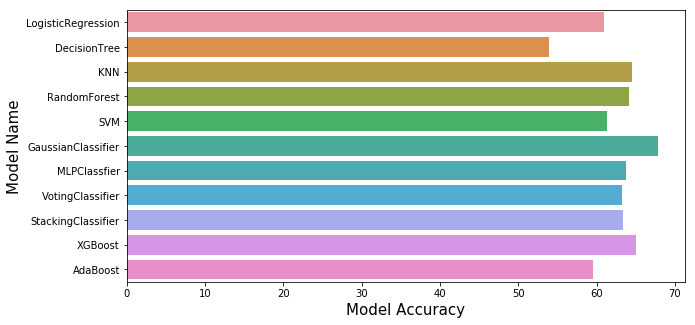

In [46]:
# Visualisation des accuracy
plt.figure(figsize=(10, 5))
sns.barplot(results['Model Accuracy'], results['Model Name'])
plt.xlabel('Model Accuracy', fontsize=15)
plt.ylabel('Model Name', fontsize=15);

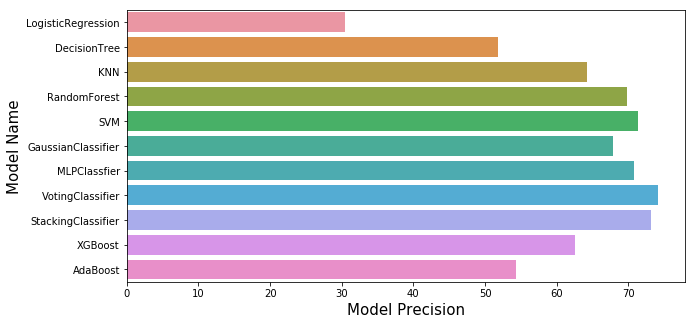

In [47]:
# Visualisation des precisions
plt.figure(figsize=(10, 5))
sns.barplot(results['Model Precision'], results['Model Name'])
plt.xlabel('Model Precision', fontsize=15)
plt.ylabel('Model Name', fontsize=15);

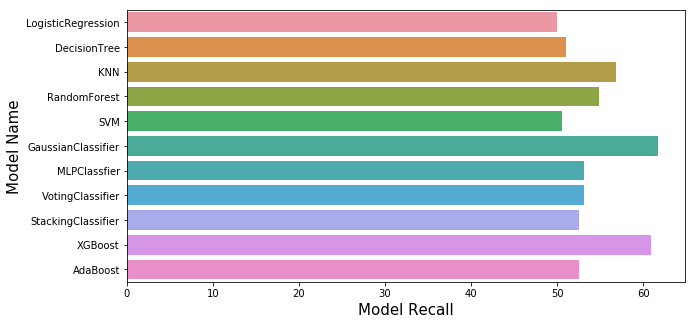

In [48]:
# Visualisation des rappels
plt.figure(figsize=(10, 5))
sns.barplot(results['Model Recall'], results['Model Name'])
plt.xlabel('Model Recall', fontsize=15)
plt.ylabel('Model Name', fontsize=15);